In [1]:
basepath = 'C:/Users/shaur/Desktop/UTD/ANLP'

In [2]:
import sys
from pathlib import Path
base_folder = Path(basepath)
data_folder = base_folder/'datasets/emotion'
model_folder = base_folder/'models/nlp_spring_2024/emotion/nn'
custom_functions = base_folder/'custom_files'
utils_folder = base_folder/'Assign/Emotion Detection/utils'

In [3]:
sys.path.append(str(custom_functions))
sys.path.append(str(utils_folder))
model_folder.mkdir(exist_ok=True, parents = True)

%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter
import re

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import emoji
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from utils import return_id_labels, compute_metrics, test_thresholds, plot_confusion_matrix
from preprocessing import strip_all_entities, clean_hashtags, filter_chars, remove_mult_spaces, demoji_text, convert_emoji

from kaggle import api

### NEW ##########################
# imports from Huggingface ecosystem
import evaluate
from datasets import load_dataset, DatasetDict, Dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
new_data_train = pd.read_csv(data_folder/"emotion_classification/2018-E-c-Es-train.txt", sep='\t')
new_data_dev = pd.read_csv(data_folder/"emotion_classification/2018-E-c-Es-dev.txt", sep='\t')
new_data_test = pd.read_csv(data_folder/"emotion_classification/2018-E-c-Es-test-gold.txt", sep='\t')
new_data = pd.concat([new_data_train, new_data_dev, new_data_test], axis=0)
new_data.drop(columns=['ID'], inplace=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7092 entries, 0 to 2853
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         7092 non-null   object
 1   anger         7092 non-null   int64 
 2   anticipation  7092 non-null   int64 
 3   disgust       7092 non-null   int64 
 4   fear          7092 non-null   int64 
 5   joy           7092 non-null   int64 
 6   love          7092 non-null   int64 
 7   optimism      7092 non-null   int64 
 8   pessimism     7092 non-null   int64 
 9   sadness       7092 non-null   int64 
 10  surprise      7092 non-null   int64 
 11  trust         7092 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 720.3+ KB


In [6]:
train = pd.read_csv(data_folder/'train.csv')
train.drop(columns=['ID'], inplace=True)
train = pd.concat([train, new_data], axis=0)
train.drop_duplicates(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14815 entries, 0 to 2853
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tweet         14815 non-null  object
 1   anger         14815 non-null  int64 
 2   anticipation  14815 non-null  int64 
 3   disgust       14815 non-null  int64 
 4   fear          14815 non-null  int64 
 5   joy           14815 non-null  int64 
 6   love          14815 non-null  int64 
 7   optimism      14815 non-null  int64 
 8   pessimism     14815 non-null  int64 
 9   sadness       14815 non-null  int64 
 10  surprise      14815 non-null  int64 
 11  trust         14815 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 1.5+ MB


In [7]:
test = pd.read_csv(data_folder/'test.csv')
id2label, label2id = return_id_labels()

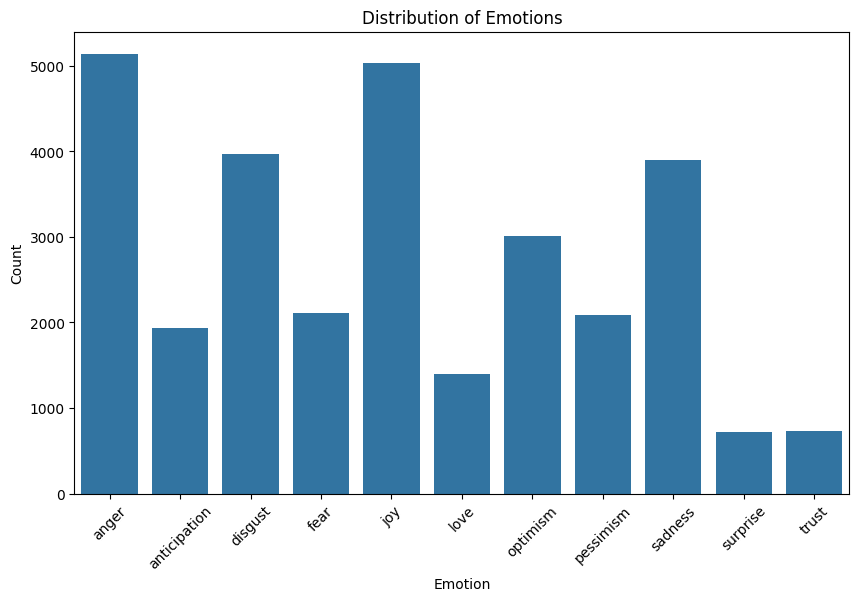

In [8]:
emotion_counts = train.drop(columns=['Tweet']).sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Preprocessing

In [9]:
train_clean = train['Tweet'].apply(demoji_text).apply(convert_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces)
train['Tweet'] = train_clean

In [10]:
X = train['Tweet'].values
y = train.loc[:, train.columns != 'Tweet'].values
y = np.array(y, dtype=float)

In [11]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, random_state=42,test_size=0.1)

In [12]:
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': y_train
})
validset = Dataset.from_dict({
    'texts': X_val,
    'labels': y_val
})

In [13]:
train_label_counts, valid_label_counts = Counter(), Counter()

def update_label_counts(dataset, label_cnts):
    for label_array in dataset['labels']:
        for i, label in enumerate(label_array):
            if label == 1.0:
                label_cnts[i] += 1

update_label_counts(trainset, train_label_counts)
update_label_counts(validset, valid_label_counts)

In [14]:
print("Training set label distribution:")
for label, cnt in train_label_counts.items():
    print(id2label[label], ": ", cnt)

Training set label distribution:
joy :  4524
love :  1272
optimism :  2710
disgust :  3559
fear :  1883
pessimism :  1893
sadness :  3518
anticipation :  1743
anger :  4606
trust :  660
surprise :  647


In [15]:
print("Valid set label distribution:")
for label, cnt in valid_label_counts.items():
    print(id2label[label], ": ", cnt)

Valid set label distribution:
anger :  536
disgust :  404
sadness :  386
anticipation :  189
optimism :  302
joy :  512
love :  120
fear :  225
surprise :  77
pessimism :  190
trust :  68


In [16]:
def calculate_pos_weights(dataset):
    num_labels = len(dataset['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    for label_array in dataset['labels']:
        for i, label in enumerate(label_array):
            if label==1.0: total_positives[i] += 1
            else: total_negatives[i] += 1
            
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

pos_weights = calculate_pos_weights(trainset)
pos_weights

tensor([ 1.8947,  6.6495,  2.7463,  6.0807,  1.9472,  9.4819,  3.9199,  6.0433,
         2.7899, 19.6074, 19.2015])

In [17]:
pos_weights = torch.tensor([2.0143,2.5297,2.1054,2.4692,2.0322,3.1575,2.2898,2.4643,2.1159,5.0000,4.9336])

## Custom Trainer

In [18]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device
        loss_fnct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fnct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [19]:
checkpoint = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [20]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [21]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
validset_tokenized = validset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
validset_tokenized = validset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')
validset_tokenized.set_format(type='torch')

Map: 100%|██████████| 1482/1482 [00:00<00:00, 51818.22 examples/s]


In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-2022-154m and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args_config = {

    'num_train_epochs': 6,
    'per_device_train_batch_size': 16,
    'per_device_eval_batch_size': 16, 
    # 'weight_decay': 0.1, # weight decay (L2 regularization)
    # 'learning_rate': 2e-5, # learning arte
    'optim': 'adamw_torch', # optimizer
}

In [24]:
run_name = "twitter_emotion_roberta_large"

training_args = TrainingArguments(
    num_train_epochs=training_args_config.get("num_train_epochs", 3),

    per_device_train_batch_size=training_args_config.get("per_device_train_batch_size", 16),
    per_device_eval_batch_size=training_args_config.get("per_device_eval_batch_size", 16),
    # weight_decay=training_args_config.get("weight_decay", 0.01),  
    # learning_rate=training_args_config.get("learning_rate", 1e-4), 
    lr_scheduler_type='linear',
    warmup_steps=50,
    weight_decay=0.1,
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'roberta_twitter_poswts_add'), 
    evaluation_strategy='steps', 
    eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    load_best_model_at_end=True, 
    save_total_limit=5, 
    metric_for_best_model="loss",
    greater_is_better=False, 

    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases
)

In [25]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

c:\Users\shaur\anaconda3\envs\anlp\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [26]:
wandb.login()

run = wandb.init(
    # Set the project where this run will be logged
    project=run_name,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": training_args_config.get("learning_rate", 1e-4),
        "epochs": training_args_config.get("num_train_epochs", 3),
        "train_batch_size": training_args_config.get("per_device_train_batch_size", 16),
        "eval_batch_size": training_args_config.get("per_device_eval_batch_size", 16),
        "weight_decay": training_args_config.get("weight_decay", 0.01)
    },
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shauryat1298 (shauryat12). Use `wandb login --relogin` to force relogin


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(trainset_tokenized)

100%|██████████| 834/834 [00:29<00:00, 27.88it/s]


{'eval_accuracy': 0.3129078226955674,
 'eval_f1': 0.6884983558037266,
 'eval_loss': 0.3733936846256256,
 'eval_runtime': 29.9461,
 'eval_samples_per_second': 445.233,
 'eval_steps_per_second': 27.85,
 'epoch': 3.0}

In [ ]:
test_results = trainer.evaluate(validset_tokenized)
test_results

100%|██████████| 93/93 [00:03<00:00, 29.51it/s]


{'eval_accuracy': 0.21322537112010798,
 'eval_f1': 0.5670967019206501,
 'eval_loss': 0.49776121973991394,
 'eval_runtime': 3.1808,
 'eval_samples_per_second': 465.916,
 'eval_steps_per_second': 29.238,
 'epoch': 3.0}

In [30]:
wandb.log({"test_accuracy": test_results["eval_accuracy"], "test_loss": test_results["eval_loss"], "test_f1": test_results["eval_f1"]})
wandb.finish()

eval/accuracy,▁▂▃▃▃▃▃▃▃▄▄▅▄▄▅▅▄▅▅▄▅▅▅▅▄█▅
eval/f1,▁▂▃▄▄▅▅▅▅▅▅▅▆▅▆▅▆▆▆▆▆▆▆▆▆█▆
eval/loss,█▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁▄
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
eval/samples_per_second,▆█▁▇▇▆▇▆▆▄▆▅▆▅▆▆▇▆▆▅▂▄▄▄▅▃▅
eval/steps_per_second,▆█▁▇▇▆▇▆▆▄▆▅▆▅▆▆▇▆▆▅▂▄▄▄▅▃▅
test_accuracy,▁
test_f1,▁
test_loss,▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████


## Evaluation

100%|██████████| 834/834 [00:28<00:00, 28.76it/s]


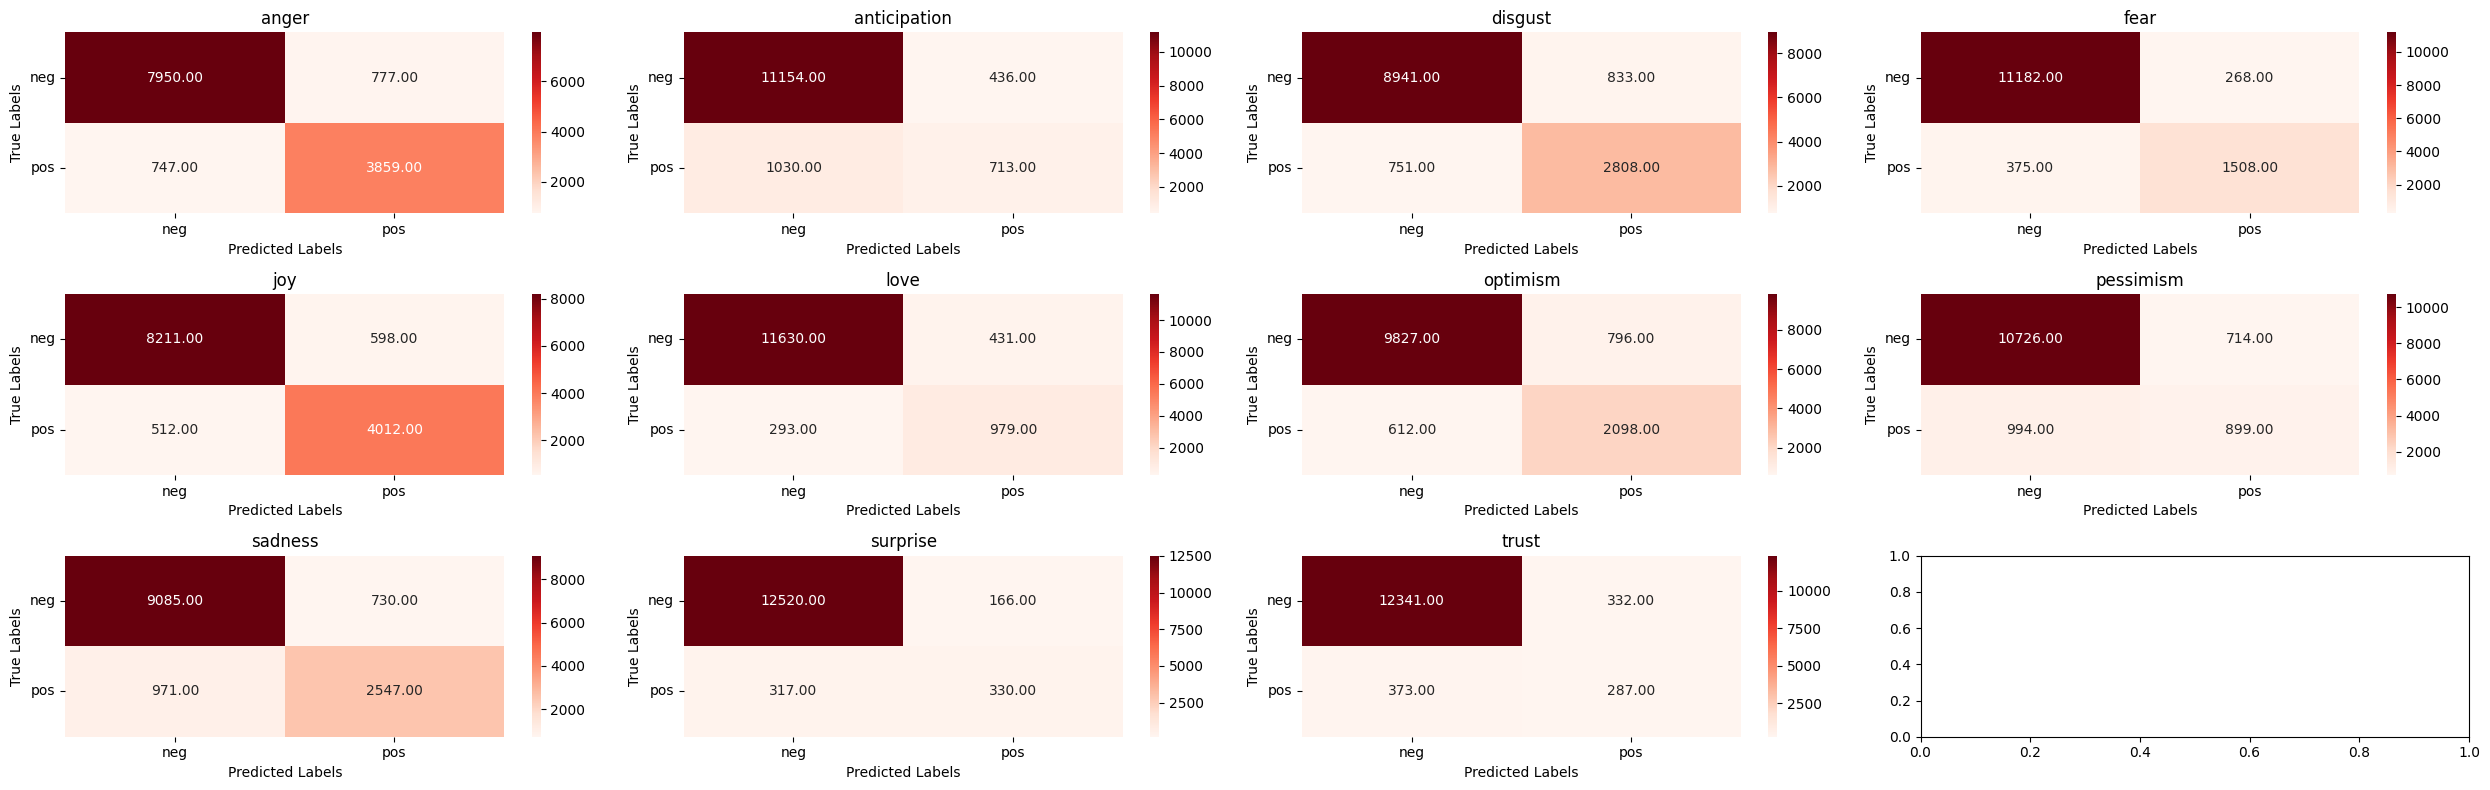

In [31]:
train_output = trainer.predict(trainset_tokenized)

train_preds = np.array(train_output.predictions)
train_preds = np.where(train_preds>0.5, 1., 0.)
train_labels = np.array(train_output.label_ids)

plot_confusion_matrix(train_labels, train_preds, class_labels=['neg', 'pos'])

100%|██████████| 93/93 [00:03<00:00, 26.34it/s]


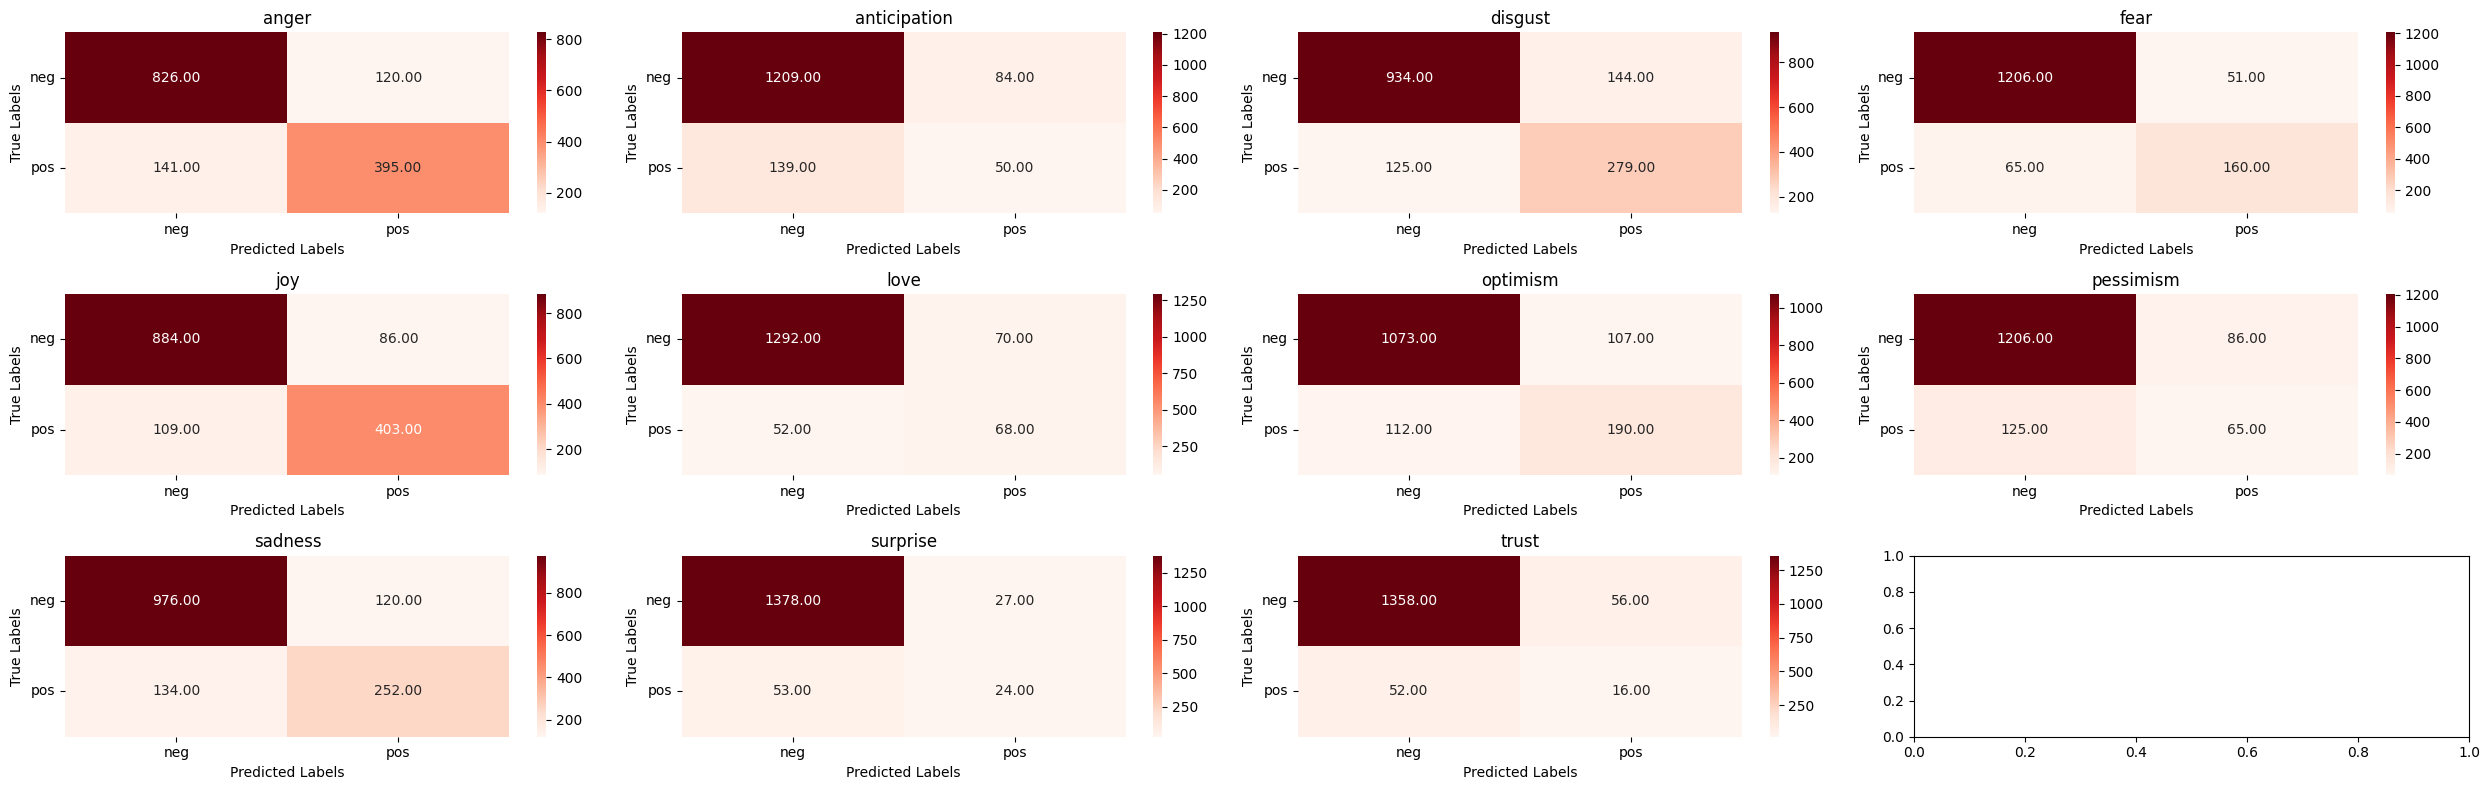

In [32]:
valid_output = trainer.predict(validset_tokenized)

valid_preds = np.array(valid_output.predictions)
valid_preds = np.where(valid_preds>0.5, 1., 0.)
valid_labels = np.array(valid_output.label_ids)

plot_confusion_matrix(valid_labels, valid_preds, class_labels=['neg', 'pos'])

In [33]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 2400.


In [34]:
print(f"The best model was saved at step {best_model_checkpoint_step}.")

model_checkpoint = model_folder/'roberta_twitter_poswts_add'/f'checkpoint-{best_model_checkpoint_step}'
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint
)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The best model was saved at step 2400.


In [35]:
checkpoint = str(model_folder/'roberta_twitter_poswts_add'/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=torch.cuda.current_device(),
    top_k=None)

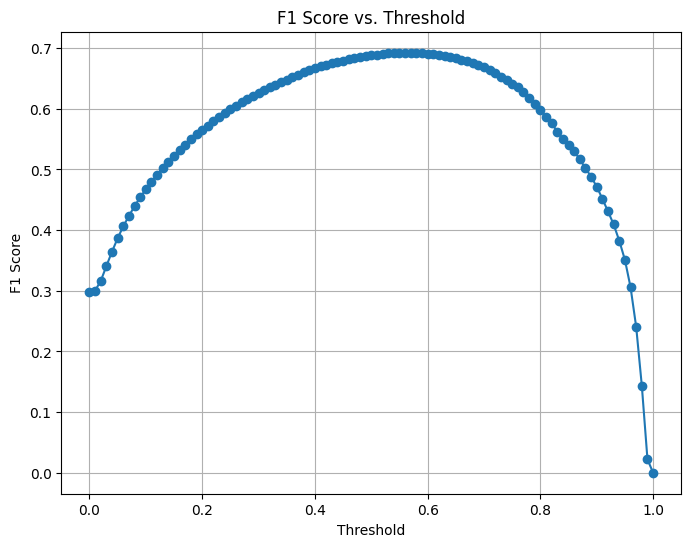

Best Threshold: 0.54
Best F1 Score: 0.6925429573485493


In [36]:
preds = custom_pipeline(trainset['texts'])
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(trainset['labels'], preds, thresholds)

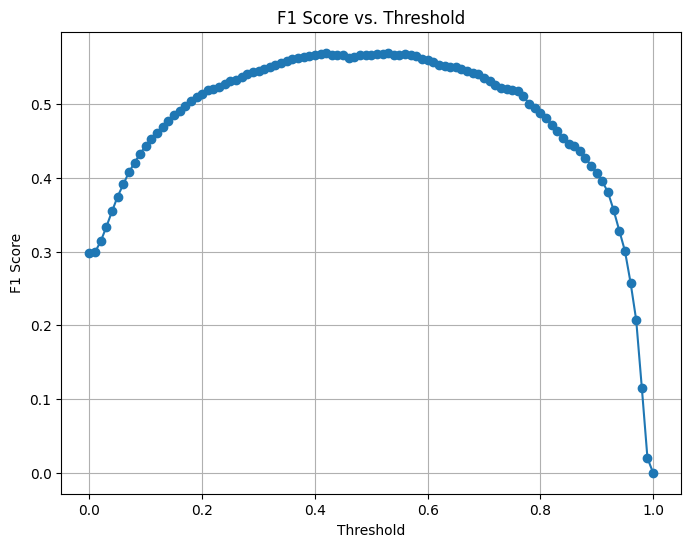

Best Threshold: 0.53
Best F1 Score: 0.570037150266206


In [37]:
preds = custom_pipeline(validset['texts'])
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(validset['labels'], preds, thresholds)

## Training on whole dataset

In [26]:
trainset = Dataset.from_dict({
    'texts': X,
    'labels': y
})

In [27]:
checkpoint = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [28]:
trainset_tokenized = trainset.map(tokenize_fn, batched=True)
trainset_tokenized = trainset_tokenized.remove_columns(['texts'])
trainset_tokenized.set_format(type='torch')

Map: 100%|██████████| 14815/14815 [00:00<00:00, 59388.68 examples/s]


In [29]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    problem_type="multi_label_classification", 
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-2022-154m and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
training_args = TrainingArguments(
    num_train_epochs=3,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # weight_decay=0.01,  
    # learning_rate=2e-5, 
    lr_scheduler_type='linear',
    warmup_steps=50,
    weight_decay=0.1,
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder/'roberta_twitter_poswts'), 
    # evaluation_strategy='steps', 
    # eval_steps=100, 
    save_strategy="steps", 
    save_steps=100, 
    # load_best_model_at_end=True, 
    save_total_limit=5, 
    metric_for_best_model="loss",
    greater_is_better=False, 
)


In [31]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=trainset_tokenized,
    # eval_dataset=validset_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shauryat1298 (shauryat12). Use `wandb login --relogin` to force relogin


 18%|█▊        | 500/2778 [01:10<04:38,  8.17it/s]

{'loss': 0.7101, 'grad_norm': 3.3397269248962402, 'learning_rate': 4.175219941348974e-05, 'epoch': 0.54}


 36%|███▌      | 1000/2778 [02:23<03:31,  8.40it/s]

{'loss': 0.6017, 'grad_norm': 2.3431787490844727, 'learning_rate': 3.2587976539589445e-05, 'epoch': 1.08}


 54%|█████▍    | 1500/2778 [03:37<02:45,  7.73it/s]

{'loss': 0.5416, 'grad_norm': 2.624940872192383, 'learning_rate': 2.342375366568915e-05, 'epoch': 1.62}


 72%|███████▏  | 2000/2778 [04:48<01:29,  8.69it/s]

{'loss': 0.5034, 'grad_norm': 3.9457058906555176, 'learning_rate': 1.4259530791788859e-05, 'epoch': 2.16}


 90%|████████▉ | 2500/2778 [06:02<00:34,  8.00it/s]

{'loss': 0.4575, 'grad_norm': 4.9908647537231445, 'learning_rate': 5.095307917888564e-06, 'epoch': 2.7}


100%|██████████| 2778/2778 [06:45<00:00,  6.85it/s]

{'train_runtime': 414.1852, 'train_samples_per_second': 107.307, 'train_steps_per_second': 6.707, 'train_loss': 0.5515964362499437, 'epoch': 3.0}


TrainOutput(global_step=2778, training_loss=0.5515964362499437, metrics={'train_runtime': 414.1852, 'train_samples_per_second': 107.307, 'train_steps_per_second': 6.707, 'train_loss': 0.5515964362499437, 'epoch': 3.0})

In [32]:
trainer.evaluate(trainset_tokenized)

100%|██████████| 926/926 [00:29<00:00, 31.13it/s]


{'eval_accuracy': 0.2982112723590955,
 'eval_f1': 0.6594444938622015,
 'eval_loss': 0.401853084564209,
 'eval_runtime': 29.8268,
 'eval_samples_per_second': 496.702,
 'eval_steps_per_second': 31.046,
 'epoch': 3.0}

## Evaluation

In [41]:
best_model_checkpoint_step = 2700
print(f"The best model was saved at step {best_model_checkpoint_step}.")

model_checkpoint = model_folder/'roberta_twitter_poswts'/f'checkpoint-{best_model_checkpoint_step}'
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint
)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The best model was saved at step 2700.


In [42]:
checkpoint = str(model_folder/'roberta_twitter_poswts'/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=torch.cuda.current_device(),
    top_k=None)

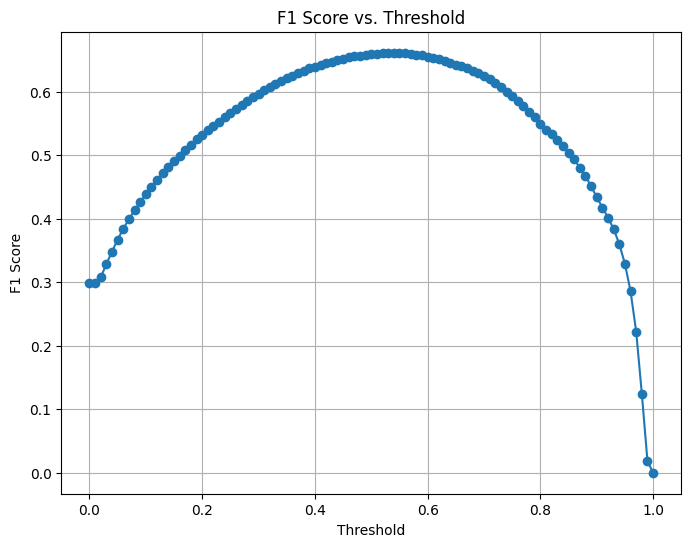

Best Threshold: 0.54
Best F1 Score: 0.6614322293407


In [43]:
preds = custom_pipeline(trainset['texts'])
thresholds = np.arange(0.0, 1.01, 0.01).tolist()
test_thresholds(trainset['labels'], preds, thresholds)

## Submission to Kaggle

In [44]:
X_test = test['Tweet']
X_test_cleaned = X_test.apply(demoji_text).apply(convert_emoji).apply(strip_all_entities).apply(clean_hashtags).apply(filter_chars).apply(remove_mult_spaces).values

In [45]:
testset = Dataset.from_dict({
    'texts': X_test_cleaned,
})

In [46]:
preds = custom_pipeline(testset['texts'])

In [47]:
pred_df = pd.DataFrame(columns=test.columns[2:])

for pred in preds:
    temp_ans = label2id
    for pred_label in pred:
        if pred_label['score']>0.54:
            temp_ans[pred_label['label']] = 1
        else: 
            temp_ans[pred_label['label']] = 0
    pred_df = pd.concat([pred_df, pd.DataFrame([temp_ans])], ignore_index=True)

In [48]:
sub_df = pd.concat([test[['ID']], pred_df], axis=1)
sub_df.to_csv(model_folder/'pos_wts_sub.csv', index = False)

In [49]:
comp = 'emotion-detection-spring2014'
api.competition_submit(model_folder/'pos_wts_sub.csv', 'Positional Wts', comp)

100%|██████████| 108k/108k [00:01<00:00, 64.8kB/s] 


Successfully submitted to Emotion Detection Spring2024